<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>Get galaxies images cutouts using TAP service and Butler</b> <br>
Contact authors: Alma Gonzalez, Luis Cantero <br>
Last verified to run: 2023-02-01 <br>
Targeted learning level: beginner <br>

**Description:** Explore the DP0.2 catalogs via TAP and execute queries to retrieve data. Also get 'cutouts' images for elliptical galaxies from Coadd images.

**Skills:** How to use the TAP service, Query catalog data with SQL, Visualize Coadd images and get 'cutouts' using Butler.

**LSST Data Products:** Object, CcdVisit tables, Butler and deepCoadd images.

**Packages:** lsst.rsp, bokeh, pandas,  lsst.afw.display, lsst.daf.butler, lsst.geom, lsst.afw.image.

**Credit:**
Various scripts have been obtained from tutorial-notebooks

## 1.0. Introduction

### Nomenclature

--**Visit**: A pair of exposures of the same area of the sky taken in immediate succession. A Visit for LSST consists of a 15 second exposure, a 2 second readout time, and a second 15
second exposure. 3 Nights are needed for an all-sky imaging.

--The image data for to a visit is a set of 189 **“CCD”** or “**detector**” images.


Our convention for defining regions on the sky is deliberately vague; we hope to build a codebase capable of working with virtually any pixelization or projection scheme.
Our approach involves two region concepts: **“tracts” and “patches”**.

--  **A tract is a large region with a single Cartesian coordinate system**; we assume it is larger than the LSST field of view, but its maximum size is essentially set by the point at which distortion in the projection becomes significant enough to affect the processing.

Both tracts and patches are defined such that each region overlaps with its neighbors, and these overlap regions must be large enough that any individual astronomical object is wholly contained in at least one tract and patch.

-- **Tracts are divided into patches**, all of which share the tract coordinate system. $[1]$

-- The **tract coordinate system** is a method for describing the position of an object in the sky. It is based on the equatorial coordinate system, which uses the celestial equator and the position of the object relative to the vernal equinox (the point where the Sun's ecliptic crosses the celestial equator) as reference. The coordinates specify the object's right ascension and declination, which correspond to longitude and latitude on the Earth. It's also known as the equatorial coordinate system.

-- **WCS (World Coordinate System)**: It is a standard specification that provides a way to associate conical or rectangular coordinates to sky images and allows for comparison of data between different instruments and observatories.

<img align="center" src = https://jira.lsstcorp.org/secure/attachment/31742/tracts_patches_UD_COSMOS_HSC-I.png width=500 style="padding: 1px"> 

$[1]$ **Data Management Science Pipelines Design:**
https://ldm-151.lsst.io/

### About the DP0.2 TAP server...

The table access protocol (TAP) defines a service protocol for accessing general table data, including astronomical catalogs as well as general database tables. 

DP0.2 contains the “wide-fast-deep” (WFD) simulated data set from the Vera C. Rubin LSST Dark Energy Science Collaboration.

This data set contains, among other material, images and catalogs for c. 300 sq deg of contiguous sky within th

The Table Access Protocol (TAP) server and ADQL (Astronomy Data Query Language) are utilized in this notebook to showcase an intermediate-level illustration of how to query and retrieve data from the DP0.2 catalogs.

The International Virtual Observatory Alliance (IVOA) offers complete documentation for TAP, which standardizes the process of discovering, searching, and retrieving catalog data. ADQL is comparable to SQL (Structured Query Language).

$[2]$ **Validation Tests of the DP0.1 TAP server on IDF:**
https://rtn-026.lsst.io/

### 1.1. Package imports

In [38]:
# plot functions
import matplotlib.pyplot as plt

# garbage collector to reduce memory footprint
import gc 

# Count number of elements in a list
from collections import Counter

# library for numerical computing
import numpy as np

import pprint

# manage and provides fast and flexible data structures 
import pandas
from pandas.testing import assert_frame_equal

# Astropy imports --> provides a common framework for astronomy in Python and is used by many astronomers and researchers in the industry
from astropy.wcs import WCS #-->  "WCS" is a class that allows handling coordinate projection information in an image file.

from astropy.visualization import make_lupton_rgb # allows creating an RGB (red, green, blue) image from three images in different frequency bands.

from astropy import units as u #provides support for physical units, including defining, handling, and converting between different unit systems

from astropy.coordinates import SkyCoord #It provides a convenient and flexible interface for working with sky coordinates in various reference frames,

# Image visualization routines.
import lsst.afw.display as afwDisplay

# The Butler projvides programmatic access to LSST data products.
from lsst.daf.butler import Butler

# Geometry package
import lsst.geom as geom

# Object for multi-band exposures
from lsst.afw.image import MultibandExposure

# library to manage folders 
import os

# library to create a fits file
from astropy.io import fits

# to save files as h5
import h5py

plt.style.use('tableau-colorblind10')
%matplotlib inline

### 1.2. Define some functions fro tutorial-nptebooks

In [6]:
# Delete an image from memory
# from: /tutorial-notebooks/03a_Image_Display_and_Manipulation.ipynb

def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint.

    Parameters
    ----------
    fig: matplotlib.figure.Figure
        Figure to be removed.

    Returns
    -------
    None
    """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # clear the figure
    plt.close(fig)  # close the figure
    gc.collect()    # call the garbage collector

In [7]:
# function to produce a cutout image from a coadd at the user-provided ra, dec.
# from: /tutorial-notebooks/03a_Image_Display_and_Manipulation.ipynb

def cutout_coadd(butler, ra, dec, band='r', datasetType='deepCoadd',
                 skymap=None, cutoutSideLength=51, **kwargs):
    """
    Produce a cutout from a coadd at the given ra, dec position.

    Adapted from DC2 tutorial notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Servant providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    band: string
        Filter of the image to load
    datasetType: string ['deepCoadd']
        Which type of coadd to load.  Doesn't support 'calexp'
    skymap: lsst.afw.skyMap.SkyMap [optional]
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

    if skymap is None:
        skymap = butler.get("skyMap")

    # Look up the tract, patch for the RA, Dec
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    xy = geom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    patch = tractInfo.getSequentialPatchIndex(patchInfo)

    coaddId = {'tract': tractInfo.getId(), 'patch': patch, 'band': band}
    parameters = {'bbox': bbox}

    cutout_image = butler.get(datasetType, parameters=parameters,
                              dataId=coaddId)

    return cutout_image

In [8]:
def createRGB(image, bgr="gri", stretch=1, Q=10, scale=None):
    """
    Create an RGB color composite image.

    Parameters
    ----------
    image : `MultibandExposure`
        `MultibandExposure` to display.
    bgr : sequence
        A 3-element sequence of filter names (i.e., keys of the exps dict)
        indicating what band to use for each channel. If `image` only has
        three filters then this parameter is ignored and the filters
        in the image are used.
    stretch: int
        The linear stretch of the image.
    Q: int
        c
    scale: list of 3 floats, each less than 1. (default: None)
        Re-scales the RGB channels.

    Returns
    -------
    rgb: ndarray
        RGB (integer, 8-bits per channel) colour image as an NxNx3 numpy array.
    """

    # If the image only has 3 bands, reverse the order of the bands
    #   to produce the RGB image
    if len(image) == 3:
        bgr = image.filters

    # Extract the primary image component of each Exposure with the
    #   .image property, and use .array to get a NumPy array view.

    if scale is None:
        r_im = image[bgr[2]].array  # numpy array for the r channel
        g_im = image[bgr[1]].array  # numpy array for the g channel
        b_im = image[bgr[0]].array  # numpy array for the b channel
    else:
        # manually re-scaling the images here
        r_im = image[bgr[2]].array * scale[0]
        g_im = image[bgr[1]].array * scale[1]
        b_im = image[bgr[0]].array * scale[2]

    rgb = make_lupton_rgb(image_r=r_im,
                          image_g=g_im,
                          image_b=b_im,
                          stretch=stretch, Q=Q)
    # "stretch" and "Q" are parameters to stretch and scale the pixel values

    return rgb

## 2.0. Catalog Data

### 2.1. Table Access Protocol (TAP) service

Table Access Procotol (TAP) provides standardized access to the catalog data for discovery, search, and retrieval.

The TAP service uses a query language similar to SQL (Structured Query Langage) called ADQL (Astronomical Data Query Language). 

Get an instance of the TAP service, and assert that it exists.

In [9]:
# USE TAP SERVICE
# Import the Rubin TAP service utilities
from lsst.rsp import get_tap_service, retrieve_query

service = get_tap_service()
assert service is not None
assert service.baseurl == "https://data.lsst.cloud/api/tap"

# A cone search on the Object table will be a common TAP query. In this example, a circle centered on (RA, Dec) = (62.0, -37.0)
# with a radius of 1 degree is used.

# center_coords = SkyCoord(62, -37, frame='icrs', unit='deg')
# search_radius = 2.0*u.deg

# print(center_coords)
# print(search_radius)

use_center_coords = "62, -37"
use_radius = "1.0"

### 2.2. Exploring catalog tables and columns with TAP

This example uses the DP0.2 Object catalog, which contains sources detected in the coadded images (also called deepCoadd images).

Results from a TAP service search are best displayed using one of two functions:

**.to_table()**: convert results to an astropy table.

**.to_table().to_pandas()**: convert to an astropy table and then to a Pandas dataframe.

The object and source catalogs store only fluxes. There are hundreds of flux-related columns, and to store them also as magnitudes would be redundant, and a waste of space.

All flux units are nanojanskies ($nJy$). To convert $nJy$ to AB magnitudes use:

$m_{AB} = -2.5log( f_{nJy}) + 31.4$
    
Also we could retrieve columns of fluxes *as magnitudes* in an ADQL query, users can do this:<br>
`scisql_nanojanskyToAbMag(g_cModelFlux) as mag_g_cModel`,


In [10]:
# Query for ellpitical galaxies

bright_galaxy_query = ("clean",
                       "extendedness == 1",
                       "mag_g_cModel- mag_i_cModel < 5",
                       "mag_g_cModel- mag_i_cModel > 1.8",
                       "mag_g_cModel- mag_r_cModel < 3",
                       "mag_g_cModel- mag_r_cModel > 0.6",
                       
                       "mag_r_cModel < 22.5",
                       "mag_r_cModel > 18",
                       "mag_g_cModel > 20",
                       "mag_i_cModel > 18.2",
                       
                       "snr_g_cModel > 10",
                       "snr_r_cModel > 10",
                       "snr_i_cModel > 10",)

In [11]:

query = "SELECT objectId, detect_isPrimary, " + \
        "coord_ra AS ra, coord_dec AS dec, tract, patch,  " + \
        "scisql_nanojanskyToAbMag(g_cModelFlux) AS mag_g_cModel, " + \
        "scisql_nanojanskyToAbMag(r_cModelFlux) AS mag_r_cModel, " + \
        "scisql_nanojanskyToAbMag(i_cModelFlux) AS mag_i_cModel, " + \
        "r_extendedness " + \
        "FROM dp02_dc2_catalogs.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), " + \
        "CIRCLE('ICRS', " + use_center_coords + ", " + use_radius + ")) = 1 " + \
        "AND detect_isPrimary = 1 " + \
        "AND scisql_nanojanskyToAbMag(g_cModelFlux) - scisql_nanojanskyToAbMag(i_cModelFlux) < 5.0 " + \
        "AND scisql_nanojanskyToAbMag(g_cModelFlux) - scisql_nanojanskyToAbMag(i_cModelFlux) > 1.8 " + \
        "AND scisql_nanojanskyToAbMag(g_cModelFlux) - scisql_nanojanskyToAbMag(r_cModelFlux) < 3.0 " + \
        "AND scisql_nanojanskyToAbMag(g_cModelFlux) - scisql_nanojanskyToAbMag(r_cModelFlux) > 0.6 " + \
        "AND scisql_nanojanskyToAbMag(r_cModelFlux) < 22.5 " + \
        "AND scisql_nanojanskyToAbMag(r_cModelFlux) > 18.0 " + \
        "AND scisql_nanojanskyToAbMag(g_cModelFlux) > 20.0 " + \
        "AND scisql_nanojanskyToAbMag(i_cModelFlux) > 18.2 " + \
        "AND r_extendedness IS NOT NULL " + \
        "AND r_extendedness > 0 "
results = service.search(query).to_table().to_pandas()

Display 'results' table now as a pandas dataframe:

In [12]:
results

,objectId,detect_isPrimary,ra,dec,tract,patch,mag_g_cModel,mag_r_cModel,mag_i_cModel,r_extendedness
0,1567929969487670941,True,61.003225,-37.599231,3637,40,22.341257,20.771771,20.172821,1.0
1,1567929969487671128,True,61.081724,-37.597762,3637,40,23.915242,22.369007,21.281788,1.0
2,1567929969487671025,True,61.072816,-37.598984,3637,40,23.931586,22.457893,21.816990,1.0
3,1567929969487671775,True,61.062111,-37.593885,3637,40,23.701203,22.251161,21.488782,1.0
4,1567929969487671516,True,61.125806,-37.593927,3637,40,23.776272,22.476762,20.733906,1.0
...,...,...,...,...,...,...,...,...,...,...
15051,1651246562594029451,True,61.427546,-37.170934,3831,6,22.463933,21.015271,20.014677,1.0
15052,1651246562594029478,True,61.293929,-37.169413,3831,6,23.816281,22.372194,21.783539,1.0
15053,1651246562594032640,True,61.282192,-37.140332,3831,6,22.844919,21.545850,20.993447,1.0
15054,1651246562594029476,True,61.290496,-37.170328,3831,6,22.333028,20.977675,20.410741,1.0


### 2.3 Display list of tracts and patches

In [13]:

def getObjectTractPatch(results, view = "all"):
    '''
    results: pandas dataframe with object tract and patch columns
    view: type of list to show. Can be "tracts" to show all unique tracts. "patches" to show all unique patches. "pairs" to show the list of objects sharing the same pair of tract-patch.
          "all" to show tract, patch and pairs lists.
    
    '''
    
    tracts = results.tract
    list_tracts = tracts.tolist()

    patchs = results.patch
    list_patchs = patchs.tolist()

    pares = zip(tracts, patchs)
    
    tracts = Counter(list_tracts)
    patchs = Counter(list_patchs)
    
    pares2 = Counter(pares)
    pairs = sorted(pares2.items(), key=lambda x: (x[0][0], x[0][1]))
    
    if (view == "pairs"):
        print('Total of Tract-Patch pairs: ', str(len(pairs)), '\n')
        print('(Tract, Patch):',)
        pprint.pprint(pairs)
    if (view == "patches"):
        print('Total of Patches: ', str(len(patchs)), '\n')
        print('Patches:',)
        pprint.pprint(patchs)
    if (view == "tracts"):
        print('\nTotal of Tracts: ', str(len(tracts)), '\n')
        print('Tracts:',)
        pprint.pprint(tracts)        
    if (view == "all"):
        print('\nTotal of Tracts: ', str(len(tracts)))
        print('Tracts: ')
        pprint.pprint(tracts)
        print('\nTotal of Patches: ', str(len(patchs)))
        print('Patches: ')
        pprint.pprint(patchs)
        print('\nTotal of Tract-Patch pairs: ', str(len(pairs)))
        print('(Tract, Patch):')
        pprint.pprint(pairs)

In [14]:
getObjectTractPatch(results, view = "pairs")

Total of Tract-Patch pairs:  86 

(Tract, Patch):
[((3637, 21), 101),
 ((3637, 22), 181),
 ((3637, 23), 123),
 ((3637, 24), 78),
 ((3637, 25), 14),
 ((3637, 28), 165),
 ((3637, 29), 242),
 ((3637, 30), 194),
 ((3637, 31), 195),
 ((3637, 32), 219),
 ((3637, 33), 26),
 ((3637, 35), 178),
 ((3637, 36), 274),
 ((3637, 37), 210),
 ((3637, 38), 185),
 ((3637, 39), 247),
 ((3637, 40), 207),
 ((3637, 41), 1),
 ((3637, 42), 162),
 ((3637, 43), 217),
 ((3637, 44), 317),
 ((3637, 45), 226),
 ((3637, 46), 184),
 ((3637, 47), 253),
 ((3637, 48), 38),
 ((3638, 27), 50),
 ((3638, 33), 178),
 ((3638, 34), 235),
 ((3638, 39), 85),
 ((3638, 40), 228),
 ((3638, 41), 244),
 ((3638, 46), 99),
 ((3638, 47), 230),
 ((3638, 48), 162),
 ((3830, 0), 178),
 ((3830, 1), 213),
 ((3830, 7), 143),
 ((3830, 8), 204),
 ((3830, 14), 150),
 ((3830, 15), 130),
 ((3830, 21), 143),
 ((3830, 22), 27),
 ((3830, 28), 24),
 ((3831, 0), 146),
 ((3831, 1), 284),
 ((3831, 2), 228),
 ((3831, 3), 276),
 ((3831, 4), 186),
 ((3831, 5

## 3.0. Retrieving image Data

DP0 delegates will most frequently interact with two types of images, calexps and deepCoAdds.

A **calex**p is a single image in a single filter.
A **deepCoAdd**, on the other hand, is a combination of multiple single images into a deep stack.

The LSST Science Pipelines categorize and store images in sections known as tracts and patches.
A **tract** is a specific area within the LSST all-sky map that is divided into smaller patches.
Each **patch** is a small, quadrilateral region within a tract that can be stored and processed on a desktop computer.

To access and display a desired image, users must specify the type of image, the tract, and the patch.

### 3.1 Create an instance for Butler

The butler is an LSST Science Pipelines software package to fetch LSST data without having to know its location or format.

Create an instance of the butler using the following DP0.2 configuration and the collection. It will return an informative statement about credentials being found.

The idea is to make it simple for users to retrieve the data they need without having to worry about technical details.

In [15]:
# Import packages for Section 3.0 Image Access
import lsst.daf.butler as dafButler
import lsst.geom
import lsst.afw.display as afwDisplay

config = 'dp02'
collection = '2.2i/runs/DP0.2'

butler = dafButler.Butler(config, collections=collection)

** a **collection** refers to a set of astronomical observations that have been taken over a certain period of time and have been processed to a certain level. This can include raw images, calibrated images, source catalogs, and other data products. The purpose of organizing data into collections is to facilitate easy access and retrieval of the data, as well as to keep track of the processing history and versioning of the data.

## 4.0 Fuctions to retrieve cutouts images

### 4.1 Display a Coadd image with it's tract, patch and band

Note: Available **Bands** in LSST instrument are: u, g, r, i, z, y

In [16]:
def showCoaddImage(butler, my_tract, my_patch, band = 'i'):
    '''
    butler: lsst.daf.persistence.Butler
        Servant providing access to a data repository
    my_tract: the image tract
    my_patch: the image patch
    band: the band to show the image
        
        
    '''    
    
    try:
        dataId = {'band': band, 'tract': my_tract, 'patch': my_patch}
        my_deepCoadd = butler.get('deepCoadd', dataId=dataId)

        afwDisplay.setDefaultBackend('matplotlib')
        fig = plt.figure(figsize=(10, 8))
        afw_display = afwDisplay.Display(1)
        afw_display.scale('asinh', 'zscale')
        afw_display.mtv(my_deepCoadd.image)
        plt.gca().axis('on')
    except:
        print("Image not found!")

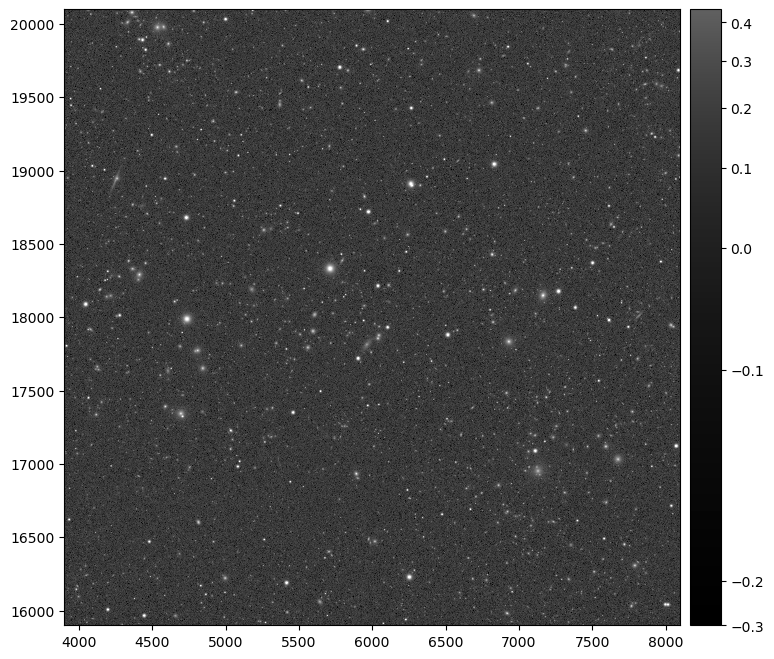

In [17]:
showCoaddImage(butler, 3637, 29, band = 'i')

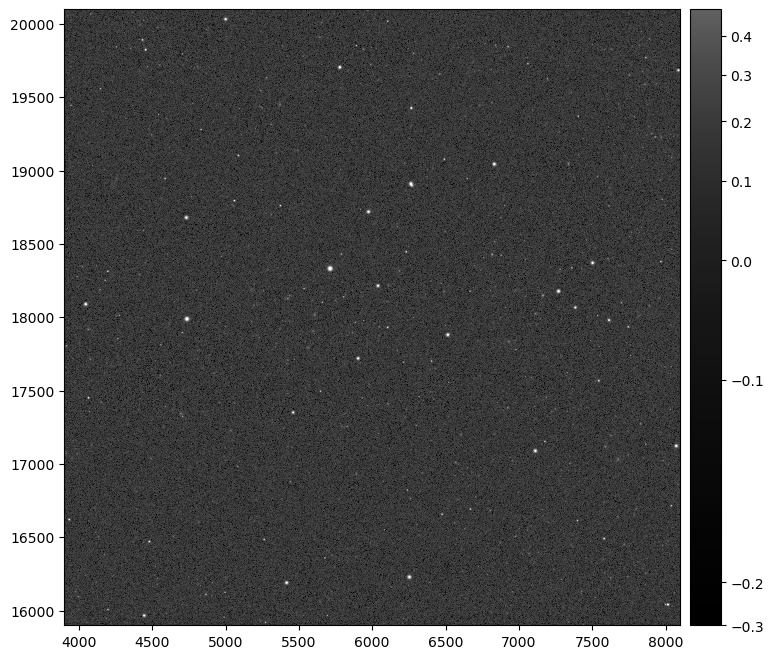

In [18]:
showCoaddImage(butler, 3637, 29, band = 'u')

### 4.2 Display only a Object cutout from ObjectId

In [19]:

def showCuoutFromObjectId(results, ObjectId, bands ="gri", cut = 60):
    
    '''
    results: pandas dataframe with object tract and patch columns
    ObjectId: the ObjectId from 'results' dataframe
    bands: string with bands name to create a 3 channels cutout
    cut: object cutout in pixels
    
    returns: Display the object Cutout image composite in the given bands
    '''
    
    band1, band2, band3 = bands
    index = results.index[results['objectId'] == ObjectId].tolist()[0]
    tract = results.tract[index]
    patch = results.patch[index]

    try:
        ra = results.ra[index]    
        dec = results.dec[index]  

        print('ObjectId = ', ObjectId)
        print('Object Ra = ', ra)
        print('Object Dec = ', dec)
        print('Object Tract = ', tract)
        print('Object Patch = ', patch)
        print('Bands: ' + band1 + " " + band2 + " " + band3)
        
        cutout_image_g = cutout_coadd(butler, ra, dec, band=band1,
                                      datasetType='deepCoadd', cutoutSideLength=cut)
        cutout_image_r = cutout_coadd(butler, ra, dec, band=band2,
                                      datasetType='deepCoadd', cutoutSideLength=cut)
        cutout_image_i = cutout_coadd(butler, ra, dec, band=band3,
                                      datasetType='deepCoadd', cutoutSideLength=cut)

        # Multiband exposures need a list of images and filters
        coadds = [cutout_image_g, cutout_image_r, cutout_image_i]
        coadds = MultibandExposure.fromExposures([band1, band2, band3], coadds)

        rgb_original = createRGB(coadds.image, bgr=[band1, band2, band3], scale=None)
        fig, ax = plt.subplots()
        ax.imshow(rgb_original)
        ax.set_axis_off()
        plt.imshow(rgb_original)
    except:
        print("Object Not Found!")


ObjectId =  1651440076640517220
Object Ra =  62.8546787
Object Dec =  -36.2957705
Object Tract =  3831
Object Patch =  28
Bands: u y i


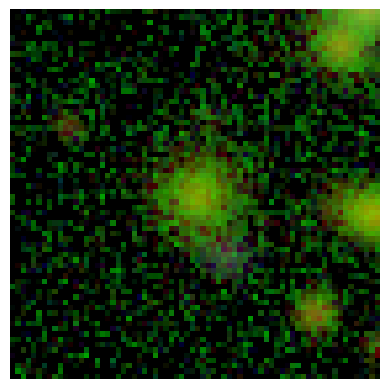

In [20]:
showCuoutFromObjectId(results, ObjectId = 1651440076640517220, bands ="uyi", cut = 70)

### 4.3 Display only a Object cutout from Object Index in 'results' table

In [21]:

def showCuoutFromObjectIndex(results, index, bands ="gri", cut = 60):
    
    '''
    results: pandas dataframe with object tract and patch columns
    index: the object index from 'results' dataframe
    bands: string with bands name to create a 3 channels cutout
    cut: object cutout in pixels
    
    returns: Display the object Cutout image composite in the given bands
    '''
    
    band1, band2, band3 = bands
    tract = results.tract[index]
    patch = results.patch[index]  
    
    try:
        ra = results.ra[index]    
        dec = results.dec[index]  
        ObjectId = results.objectId[index]  
      
        print('ObjectId = ', ObjectId)
        print('Object Ra = ', ra)
        print('Object Dec = ', dec)
        print('Object Tract = ', tract)
        print('Object Patch = ', patch)
        print('Bands: ' + band1 + " " + band2 + " " + band3)  
        
        cutout_image_g = cutout_coadd(butler, ra, dec, band=band1,
                                      datasetType='deepCoadd', cutoutSideLength=cut)
        cutout_image_r = cutout_coadd(butler, ra, dec, band=band2,
                                      datasetType='deepCoadd', cutoutSideLength=cut)
        cutout_image_i = cutout_coadd(butler, ra, dec, band=band3,
                                      datasetType='deepCoadd', cutoutSideLength=cut)

        # Multiband exposures need a list of images and filters
        coadds = [cutout_image_g, cutout_image_r, cutout_image_i]
        coadds = MultibandExposure.fromExposures([band1, band2, band3], coadds)

        rgb_original = createRGB(coadds.image, bgr=[band1, band2, band3], scale=None)
        fig, ax = plt.subplots()
        ax.imshow(rgb_original)
        ax.set_axis_off()
        plt.imshow(rgb_original)
    except:
        print("Object Not Found!")


ObjectId =  1567929969487670941
Object Ra =  61.0032254
Object Dec =  -37.5992313
Object Tract =  3637
Object Patch =  40
Bands: u r i


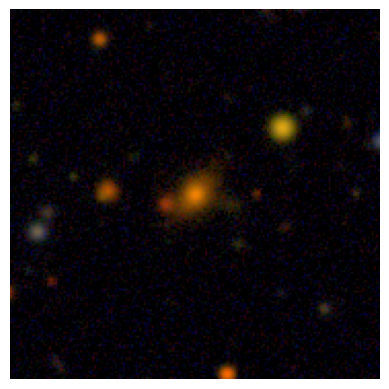

In [22]:
showCuoutFromObjectIndex(results, 0, bands ="uri", cut = 180)

### 4.4 Saving all cutouts given a range of index in 'results' table

In [23]:
# this function saves the images according to a given range using 'results' table

def getCuttedImagesInRange(results, rango_i = 0, rango_f = 5, bands ="gri", cut = 60, path = ""):
    '''
    results: pandas dataframe with object tract and patch columns
    rango_i: index of first element to retrieve
    rango_f: index of last element to retrieve
    bands: string with bands name to create a 3 channels cutout
    cut: object cutout in pixels
    path: the path to save the cutouts
    
    returns: a set of images saved in the given path as PNG. Each image has the OjectID_bands as name
    '''
    
    fig = plt.figure(figsize=(20,100)) 

    band1, band2, band3 = bands
    
    for i in range(rango_i, rango_f):  

        index = i
        ra = results.ra[index]    
        dec = results.dec[index]  

        try:
            cutout_image_g = cutout_coadd(butler, ra, dec, band=band1,
                                          datasetType='deepCoadd', cutoutSideLength = cut)
            cutout_image_r = cutout_coadd(butler, ra, dec, band=band2,
                                          datasetType='deepCoadd', cutoutSideLength = cut)
            cutout_image_i = cutout_coadd(butler, ra, dec, band=band3,
                                          datasetType='deepCoadd', cutoutSideLength = cut)
        except:
            print("No se pudo hacer el corte para esta imagen. objectId: " + str(results.objectId[index])) 
        
        # Multiband exposures need a list of images and filters
        coadds = [cutout_image_g, cutout_image_r, cutout_image_i]
        coadds = MultibandExposure.fromExposures([band1, band2, band3], coadds)

        rgb_original = createRGB(coadds.image, bgr=[band1, band2, band3], scale=None)
        fig, ax = plt.subplots()
        ax.imshow(rgb_original)
        ax.set_axis_off()
        plt.imshow(rgb_original)
    
        ruta = path + str(results.objectId[index]) + '_' + bands + '.png'

        plt.savefig(ruta, bbox_inches='tight',pad_inches = 0, dpi=36) 
        remove_figure(fig)
    plt.show()  
    print('Done.\n')

In [24]:
path1  =  f'/home/luiseduardocantero/notebooks/pruebas/'
#getCuttedImagesInRange(results, rango_i = 0, rango_f = 5, bands ="gui", cut = 80, path = path1)

### 4.5 Saving all cutouts from a given tract and patch from 'results' table

In [25]:
# this function saves all the images according to a given tract and patch using 'results' table

def getCuttedImagesByTractPatch(results, tract, patch, bands ="gri", cut = 60, path = ""):
    '''
    results: pandas dataframe with object tract and patch columns
    tract: integer
    patch: integer
    bands: string with bands name to create a 3 channels cutout
    cut: object cutout in pixels
    path: the path to save the cutouts
    
    returns: a set of images saved in the given path as PNG. Each image has the OjectID_tarct_patch_bands as name
    '''
    
    fig = plt.figure(figsize=(20,100)) 
    for i in range(0, len(results)):
        index = i
        if (results.tract[index] == tract and results.patch[index] == patch):           
                   
            ra = results.ra[index]    
            dec = results.dec[index]  

            try:
                cutout_image_g = cutout_coadd(butler, ra, dec, band='g',
                                              datasetType='deepCoadd', cutoutSideLength = cut)
                cutout_image_r = cutout_coadd(butler, ra, dec, band='r',
                                              datasetType='deepCoadd', cutoutSideLength = cut)
                cutout_image_i = cutout_coadd(butler, ra, dec, band='i',
                                              datasetType='deepCoadd', cutoutSideLength = cut)
            except:
                print("No se pudo hacer el corte para esta imagen. objectId: " + str(results.objectId[index]))    
        
            # Multiband exposures need a list of images and filters
            coadds = [cutout_image_g, cutout_image_r, cutout_image_i]
            coadds = MultibandExposure.fromExposures(['g', 'r', 'i'], coadds)

            rgb_original = createRGB(coadds.image, bgr=['g', 'r', 'i'], scale=None)
            fig, ax = plt.subplots()
            ax.imshow(rgb_original)
            ax.set_axis_off()
            plt.imshow(rgb_original)
    
            ruta = path + str(results.objectId[index]) + '_' + str(tract) + '_' + str(patch) + '_' + bands  +  '.png'

            plt.savefig(ruta, bbox_inches='tight',pad_inches = 0, dpi=36) # dpi=36 para que den 217x217 pxls
            remove_figure(fig)
        plt.show()   
    print('Done.\n')        

In [26]:
path2 = f'/home/luiseduardocantero/notebooks/pruebas/'
#getCuttedImagesByTractPatch(results, tract = 3637, patch = 25, cut = 150, path = path2)

### 4.6 Saving all images in a directory (png or jpg) to a fits file

Given a directory path, all images contained will be compressed in a fits file. The function also needs the directory destination path

In [29]:

def save_images_to_fits(src_dir, dst_dir):
    # Verifica si el directorio de destino existe, de lo contrario lo crea
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)

    # Crea una lista para almacenar las imágenes
    images = []

    # Itera sobre todos los archivos en el directorio de origen
    for filename in os.listdir(src_dir):
        # Verifica si el archivo es una imagen
        if filename.endswith(".jpg") or filename.endswith(".png"):
            # Abre la imagen usando OpenCV
            image = plt.imread(os.path.join(src_dir, filename))

            # Agrega la imagen a la lista
            images.append(image)

    # Concatena todas las imágenes en una sola matriz
    concatenated_image = np.concatenate(images, axis=0)

    # Crea un archivo FITS
    hdu = fits.PrimaryHDU(concatenated_image)

    # Guarda el archivo FITS en el directorio de destino
    hdu.writeto(os.path.join(dst_dir, "images.fits"))



In [30]:
# Ejemplo de uso
src_dir = path2
dst_dir = f'/home/luiseduardocantero/notebooks/'
save_images_to_fits(src_dir, dst_dir)

To open the file created run the next cell

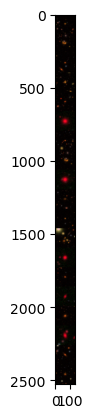

In [35]:
fits_file = f'/home/luiseduardocantero/notebooks/images.fits'
fits_images = fits.open(fits_file)
fits_data = fits_images[0].data
plt.imshow(fits_data)
plt.show()

### 4.7 Saving all images in a directory (png or jpg) to a h5 file

Given a directory path, all images contained will be compressed in a h5 file. The function also needs the directory destination path

In [39]:
def save_images_to_h5(src_dir, dst_dir):
    with h5py.File(os.path.join(dst_dir, "images.h5"), "w") as f:
        for filename in os.listdir(src_dir):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                image = plt.imread(os.path.join(src_dir, filename))
                image_dataset = f.create_dataset(filename, data=image)


In [40]:
src_dir = path2
dst_dir = f'/home/luiseduardocantero/notebooks/'
save_images_to_h5(src_dir, dst_dir)

To open the file created run the next cell

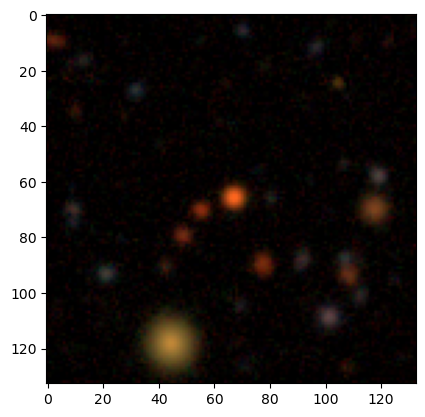

In [41]:
filename =  f'/home/luiseduardocantero/notebooks/images.h5'

with h5py.File(filename, "r") as f:
    for key in f.keys():
        image_dataset = f[key]
        image = np.array(image_dataset)
        plt.imshow(image)
        plt.show()
        break